In [1]:
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, ExponentialFitter
from Exponential import ExponentialAFTFitter
from lifelines.utils import k_fold_cross_validation
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

In [8]:
pip install --upgrade lifelines


Requirement already up-to-date: lifelines in /Users/ofelya/opt/anaconda3/lib/python3.8/site-packages (0.27.8)
Note: you may need to restart the kernel to use updated packages.


In [81]:
warnings.filterwarnings("ignore")

In [82]:
data_path = 'telco.csv'
r_telco = pd.read_csv(data_path)

In [83]:
def process_data(telco):
    telco = telco.copy()
    
    # Remove the 'ID' column
    telco.drop(['ID'], axis=1, inplace=True)
    
    # Define categorical columns for one-hot encoding
    categorical_cols = ['region', 'retire', 'marital', 'ed', 'gender', 'voice', 'internet', 'custcat', 'churn', 'forward']
    
    # Make a copy and apply one-hot encoding for categorical columns
    telco = telco.copy()
    telco = pd.get_dummies(telco, columns=categorical_cols, drop_first=True)
    
    # Rename the column 'churn_Yes' to 'churn'
    telco = telco.rename(columns={'churn_Yes': 'churn'})
    
    return telco


In [84]:
telco = process_data(r_telco)
telco

,tenure,age,address,income,region_Zone 2,region_Zone 3,retire_Yes,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,gender_Male,voice_Yes,internet_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn,forward_Yes
0,13,44,9,64,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
1,11,33,7,136,0,1,0,0,0,0,1,0,1,1,0,0,0,1,1,1
2,68,52,24,116,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,33,33,12,33,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,23,30,9,30,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,39,0,27,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
996,7,34,2,22,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
997,67,59,40,944,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,1
998,70,49,18,87,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1


AFT Models

In [85]:
weibull_model = WeibullAFTFitter()
log_logistic_model = LogLogisticAFTFitter()
exponential_model = ExponentialAFTFitter()
log_norm_model = LogNormalAFTFitter()


In [86]:
weibull = weibull_model.fit(telco, duration_col='tenure', event_col='churn')
weibull_prediction = weibull.predict_survival_function(telco).T
weibull_prediction_avg = weibull_prediction.mean()
weibull.print_summary()

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.WeibullAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.17
         time fit was run = 2023-11-30 16:29:37 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                               
lambda_ address                           0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
        age                               0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
        custcat_E-service                 0.98       2.66       0.16             0.67             1.28                 1.96                 3.61
        custcat_Plus service              0.74       2.10       0.19             0.36             1.12                 1.44                 3.06
        custcat_Total service             1.00       2.71       0.21             0.58             1.41                 1.78                 4.11
        ed_Did not complete high school   0.44       1.55       0.19             0.06             0.82                 1.06                 2.27
        ed_High school degree             0.32       1.38       0.15             0.03             0.61                 1.03                 1.83
        ed_Post-undergraduate degree      0.22       1.25       0.19            -0.15             0.60                 0.86                 1.82
        ed_Some college                   0.25       1.29       0.14            -0.03             0.54                 0.97                 1.71
        forward_Yes                      -0.10       0.91       0.15            -0.39             0.19                 0.68                 1.21
        gender_Male                       0.00       1.00       0.10            -0.20             0.21                 0.82                 1.23
        income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        internet_Yes                     -0.77       0.46       0.14            -1.04            -0.50                 0.35                 0.61
        marital_Unmarried                -0.35       0.71       0.10            -0.55            -0.14                 0.58                 0.87
        region_Zone 2                    -0.06       0.94       0.13            -0.31             0.19                 0.73                 1.21
        region_Zone 3                     0.12       1.12       0.13            -0.13             0.36                 0.87                 1.44
        retire_Yes                        0.17       1.19       0.52            -0.85             1.19                 0.43                 3.30
        voice_Yes                        -0.34       0.72       0.15            -0.63            -0.04                 0.53                 0.96
        Intercept                         2.78      16.14       0.27             2.25             3.31                 9.48                27.47
rho_    Intercept                         0.17       1.19       0.05             0.07             0.27                 1.08                 1.32

                                          cmp to     z      p   -log2(p)
param   covariate                                                       
lambda_ address                             0.00  4.69 <0.005      18.47
        age                                 0.00  4.12 <0.005      14.69
        custcat_E-service                   0.00  6.28 <0.005      31.44
        custcat_Plus service                0.00  3.83 <0.005      12.95
        custcat_Total service           

In [87]:
log_logistic = log_logistic_model.fit(telco, duration_col='tenure', event_col='churn')
log_logistic_prediction = log_logistic.predict_survival_function(telco).T
log_logistic_prediction_avg = log_logistic_prediction.mean()
log_logistic.print_summary()

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.LogLogisticAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1458.10
         time fit was run = 2023-11-30 16:29:39 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
alpha_ address                           0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.04       2.83       0.17             0.72             1.36                 2.05                 3.91
       custcat_Plus service              0.86       2.37       0.21             0.45             1.27                 1.57                 3.57
       custcat_Total service             1.20       3.33       0.24             0.73             1.67                 2.08                 5.34
       ed_Did not complete high school   0.43       1.54       0.20             0.04             0.82                 1.05                 2.28
       ed_High school degree             0.34       1.40       0.15             0.03             0.64                 1.03                 1.89
       ed_Post-undergraduate degree     -0.02       0.98       0.22            -0.45             0.40                 0.64                 1.49
       ed_Some college                   0.24       1.27       0.16            -0.06             0.55                 0.94                 1.73
       forward_Yes                      -0.19       0.82       0.17            -0.53             0.14                 0.59                 1.15
       gender_Male                       0.04       1.04       0.11            -0.18             0.26                 0.84                 1.29
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.80       0.45       0.14            -1.07            -0.52                 0.34                 0.60
       marital_Unmarried                -0.45       0.64       0.11            -0.66            -0.23                 0.52                 0.80
       region_Zone 2                    -0.05       0.95       0.14            -0.31             0.22                 0.73                 1.24
       region_Zone 3                     0.11       1.12       0.14            -0.15             0.38                 0.86                 1.46
       retire_Yes                        0.06       1.06       0.48            -0.87             1.00                 0.42                 2.71
       voice_Yes                        -0.40       0.67       0.16            -0.72            -0.08                 0.49                 0.92
       Intercept                         2.33      10.33       0.28             1.78             2.89                 5.95                17.93
beta_  Intercept                         0.34       1.40       0.05             0.24             0.44                 1.27                 1.55

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
alpha_ address                             0.00  4.42 <0.005      16.60
       age                                 0.00  4.67 <0.005      18.36
       custcat_E-service                   0.00  6.30 <0.005      31.62
       custcat_Plus service                0.00  4.13 <0.005      14.74
       custcat_Total service               0.00  5.00 <0.005    

In [89]:
exponential = exponential_model.fit(telco, duration_col='tenure', event_col='churn')
exponential_prediction = exponential.predict_survival_function(telco).T
exponential_prediction_avg = exponential_prediction.mean()
exponential.print_summary()

AttributeError: 'CovariateParameterMappings' object has no attribute 'items'

In [90]:
log_norm = log_norm_model.fit(telco, duration_col='tenure', event_col='churn')
log_norm_prediction = log_norm.predict_survival_function(telco).T
log_norm_prediction_avg = log_norm_prediction.mean()
log_norm.print_summary()

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.01
         time fit was run = 2023-11-30 16:29:48 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.07       2.90       0.17             0.73             1.40                 2.08                 4.06
       custcat_Plus service              0.92       2.52       0.22             0.50             1.35                 1.65                 3.85
       custcat_Total service             1.20       3.32       0.25             0.71             1.69                 2.03                 5.42
       ed_Did not complete high school   0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.32       1.37       0.16            -0.00             0.64                 1.00                 1.89
       ed_Post-undergraduate degree     -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.50
       ed_Some college                   0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
       forward_Yes                      -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.17
       gender_Male                       0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.77       0.46       0.14            -1.05            -0.49                 0.35                 0.61
       marital_Unmarried                -0.46       0.63       0.12            -0.68            -0.23                 0.51                 0.80
       region_Zone 2                    -0.10       0.91       0.14            -0.38             0.18                 0.69                 1.20
       region_Zone 3                     0.05       1.05       0.14            -0.23             0.33                 0.80                 1.38
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.43       0.65       0.17            -0.76            -0.10                 0.47                 0.90
       Intercept                         2.36      10.61       0.29             1.79             2.94                 5.98                18.84
sigma_ Intercept                         0.28       1.32       0.05             0.19             0.37                 1.20                 1.44

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    address                             0.00  4.78 <0.005      19.11
       age                                 0.00  4.50 <0.005      17.19
       custcat_E-service                   0.00  6.25 <0.005      31.21
       custcat_Plus service                0.00  4.29 <0.005      15.75
       custcat_Total service               0.00  4.79 <0.005      

In [91]:
print(f'Weibull AIC: {weibull.AIC_}')
print(f'Exponential AIC: {exponential.AIC_}')
print(f'Log-Normal AIC: {log_norm.AIC_}')
print(f'Log-Logistic AIC: {log_logistic.AIC_}')


scores = {'Exponential': exponential.AIC_, 'Log-normal': log_norm.AIC_, 'Log-logistic': log_logistic.AIC_, 'Weibull': weibull.AIC_}
print(f'\nThe best model based on AIC scores is: \033[1m{min(scores, key=scores.get)}\033[0m')

Weibull AIC: 2964.343248083881
Exponential AIC: 3050.873920498042
Log-Normal AIC: 2954.0240102517128
Log-Logistic AIC: 2956.2085614433336

The best model based on AIC scores is: Log-normal



Apart from the AIC score and visual representations, several other crucial considerations influence the selection of the optimal model. For instance, model complexity plays a vital role, gauged by the number of parameters within each model. Both Log-Normal and Log-Logistic models possess three parameters, while the Weibull model has two and the exponential model has just one parameter. Consequently, among these four models, the exponential model emerges as the least complex.

Another significant aspect to contemplate is the hazard rate. In cases where the data demonstrates a non-constant hazard rate, the Weibull model might be favored over the exponential model. This preference stems from the Weibull model's capability to encapsulate both increasing and decreasing hazard rates.

Nonetheless, if my primary focus remains on selecting the best-performing model, I prioritize the AIC score. Based on this criterion, I opt for the Log-Normal model as the most suitable choice.

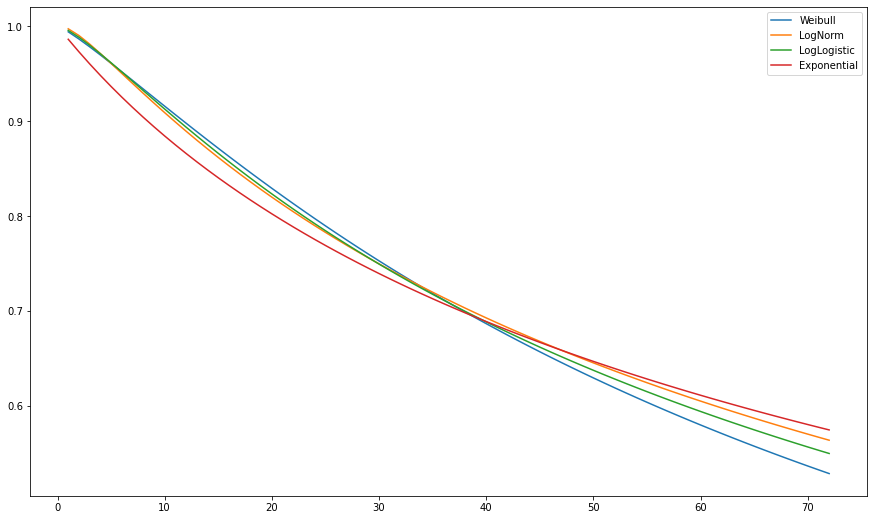

In [92]:
plt.figure(figsize=(15,9))
plt.plot(weibull_prediction_avg, label='Weibull')
plt.plot(log_norm_prediction_avg, label='LogNorm')
plt.plot(log_logistic_prediction_avg, label='LogLogistic')
plt.plot(exponential_prediction_avg, label='Exponential')
plt.legend()
plt.show()

In [93]:
sign_columns = ["address", "age", "internet_Yes", "marital_Unmarried", "tenure", "churn", "custcat_E-service", "custcat_Plus service", "custcat_Total service", "voice_Yes"]

In [94]:
d_telco = telco[sign_columns]
d_telco

,address,age,internet_Yes,marital_Unmarried,tenure,churn,custcat_E-service,custcat_Plus service,custcat_Total service,voice_Yes
0,9,44,0,0,13,1,0,0,0,0
1,7,33,0,0,11,1,0,0,1,1
2,24,52,0,0,68,0,0,1,0,0
3,12,33,0,1,33,1,0,0,0,0
4,9,30,0,0,23,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
995,0,39,0,1,10,0,0,0,0,0
996,2,34,0,1,7,0,0,0,0,0
997,40,59,1,1,67,0,0,0,1,1
998,18,49,0,1,70,0,0,1,0,1


In [95]:
log_norm = log_norm_model.fit(d_telco, duration_col='tenure', event_col='churn')
log_norm_prediction = log_norm.predict_survival_function(d_telco).T
log_norm_prediction_avg = log_norm_prediction.mean()
log_norm.print_summary()

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.10
         time fit was run = 2023-11-30 16:30:26 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    address                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service       1.03       2.79       0.17             0.69             1.36                 2.00                 3.89
       custcat_Plus service    0.82       2.28       0.17             0.49             1.15                 1.63                 3.17
       custcat_Total service   1.01       2.75       0.21             0.60             1.42                 1.83                 4.15
       internet_Yes           -0.84       0.43       0.14            -1.11            -0.57                 0.33                 0.57
       marital_Unmarried      -0.45       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       voice_Yes              -0.46       0.63       0.17            -0.79            -0.14                 0.45                 0.87
       Intercept               2.53      12.62       0.24             2.06             3.01                 7.84                20.30
sigma_ Intercept               0.28       1.33       0.05             0.19             0.37                 1.21                 1.45

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    address                   0.00  4.84 <0.005      19.56
       age                       0.00  5.75 <0.005      26.78
       custcat_E-service         0.00  6.07 <0.005      29.53
       custcat_Plus service      0.00  4.85 <0.005      19.66
       custcat_Total service     0.00  4.83 <0.005      19.52
       internet_Yes              0.00 -6.08 <0.005      29.63
       marital_Unmarried         0.00 -3.91 <0.005      13.39
       voice_Yes                 0.00 -2.78   0.01       7.52
       Intercept                 0.00 10.45 <0.005      82.47
sigma_ Intercept                 0.00  6.15 <0.005      30.27
---
Concordance = 0.79
AIC = 2944.20
log-likelihood ratio test = 280.83 on 8 df
-log2(p) of ll-ratio test = 183.73

CLV

In [96]:
clv_telco = log_norm_prediction.copy()

In [97]:
margin = 1000
sequence = range(1,len(clv_telco.columns)+1)
r = 0.1

In [98]:
for i in sequence:
    clv_telco.loc[:, i] = clv_telco.loc[:, i]/((1+r/12)**(sequence[i-1]-1))

In [99]:
clv_telco["CLV"] = margin * clv_telco.sum(axis = 1)
clv_telco

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,CLV
0,0.999688,0.989880,0.978868,0.966893,0.954194,0.940967,0.927370,0.913526,0.899533,0.885469,...,0.363526,0.357889,0.352351,0.346911,0.341567,0.336317,0.331159,0.326092,0.321112,43421.920852
1,0.999736,0.990127,0.979439,0.967868,0.955620,0.942870,0.929761,0.916405,0.902892,0.889296,...,0.373555,0.367869,0.362283,0.356792,0.351396,0.346093,0.340880,0.335756,0.330720,44012.968135
2,0.999999,0.991724,0.983496,0.975307,0.967152,0.959028,0.950934,0.942869,0.934834,0.926828,...,0.561230,0.555839,0.550497,0.545202,0.539956,0.534757,0.529605,0.524500,0.519441,53279.464095
3,0.997985,0.982516,0.963596,0.942708,0.920782,0.898406,0.875956,0.853676,0.831726,0.810209,...,0.236111,0.231513,0.227024,0.222639,0.218356,0.214171,0.210084,0.206089,0.202185,34882.879434
4,0.999870,0.990870,0.981213,0.970970,0.960245,0.949137,0.937733,0.926110,0.914328,0.902440,...,0.413868,0.408046,0.402314,0.396671,0.391115,0.385646,0.380260,0.374959,0.369738,46287.751605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.996036,0.975404,0.950272,0.923094,0.895196,0.867318,0.839884,0.813132,0.787198,0.762150,...,0.187415,0.183429,0.179547,0.175765,0.172079,0.168488,0.164988,0.161575,0.158249,30970.665732
996,0.995073,0.972135,0.944405,0.914717,0.884526,0.854605,0.825374,0.797056,0.769766,0.743549,...,0.172052,0.168286,0.164620,0.161053,0.157579,0.154197,0.150903,0.147695,0.144569,29633.260935
997,0.999991,0.991651,0.983268,0.974822,0.966311,0.957738,0.949110,0.940436,0.931725,0.922986,...,0.518455,0.512743,0.507093,0.501505,0.495977,0.490511,0.485104,0.479757,0.474468,51473.533992
998,0.999923,0.991186,0.982008,0.972409,0.962449,0.952190,0.941692,0.931008,0.920183,0.909257,...,0.440037,0.434174,0.428396,0.422700,0.417087,0.411554,0.406100,0.400725,0.395427,47681.088097


In [100]:
r_telco["CLV"] = clv_telco.CLV

Customers with higher CLV have higher probability of staying in the company

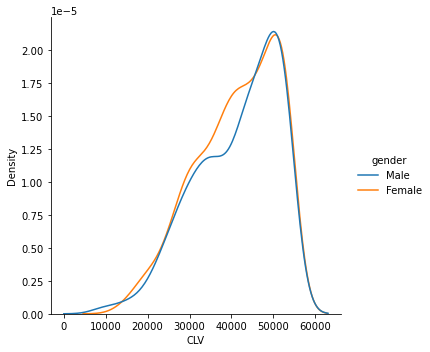

In [101]:
sns.displot(data = r_telco, kind='kde', x='CLV', hue='gender')

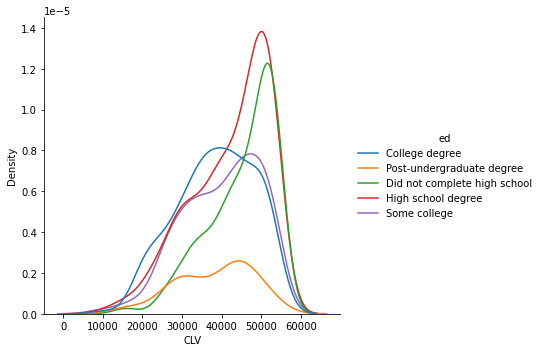

In [102]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='ed')

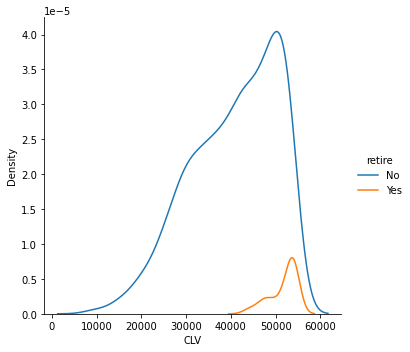

In [103]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='retire')

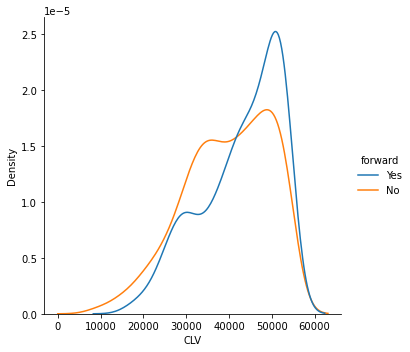

In [108]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='forward')

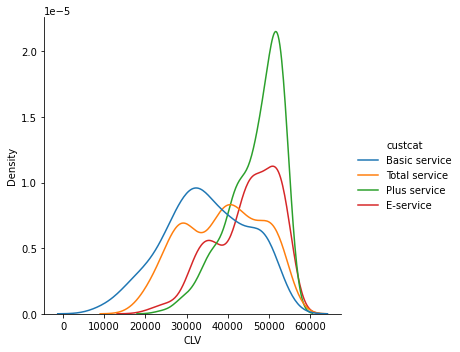

In [104]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='custcat')

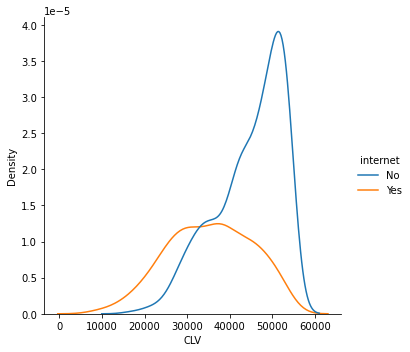

In [107]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='internet')

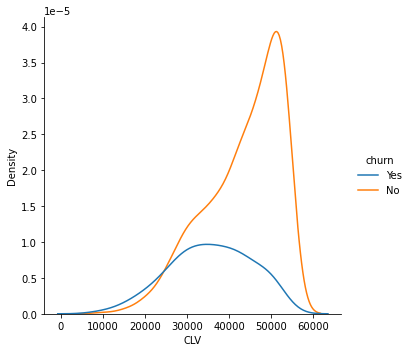

In [110]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='churn')

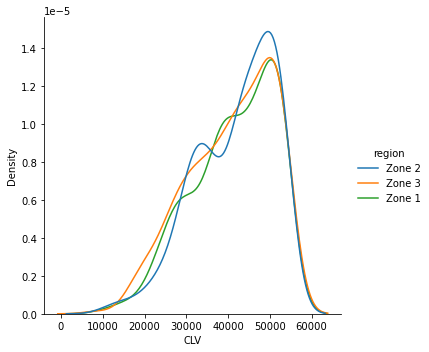

In [105]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='region')

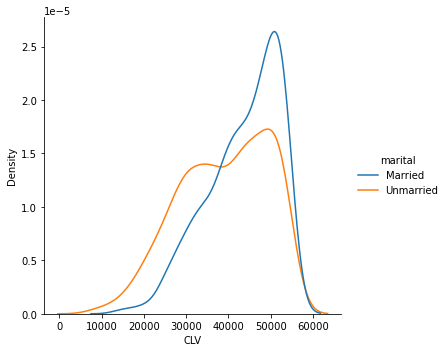

In [106]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='marital')

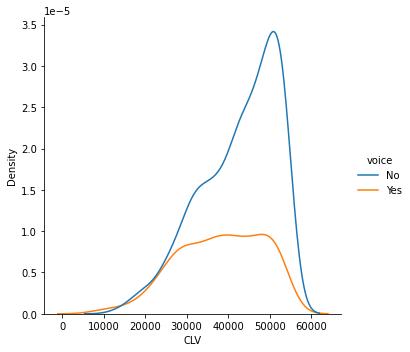

In [109]:
sns.displot(data=r_telco, kind='kde', x='CLV', hue='voice')

In [112]:
print(r_telco.groupby("gender")[["CLV"]].mean())
print(r_telco.groupby("forward")[["CLV"]].mean())
print(r_telco.groupby("voice")[["CLV"]].mean())
print(r_telco.groupby("marital")[["CLV"]].mean())
print(r_telco.groupby("region")[["CLV"]].mean())

print(r_telco.groupby("internet")[["CLV"]].mean())
print(r_telco.groupby("custcat")[["CLV"]].mean())
print(r_telco.groupby("retire")[["CLV"]].mean())
print(r_telco.groupby("ed")[["CLV"]].mean())

                 CLV
gender              
Female  41126.506961
Male    41326.642952
                  CLV
forward              
No       39698.658898
Yes      42790.978870
                CLV
voice              
No     42575.461690
Yes    38127.142462
                    CLV
marital                
Married    43569.470093
Unmarried  38923.336531
                 CLV
region              
Zone 1  41306.111183
Zone 2  41722.324987
Zone 3  40660.896214
                   CLV
internet              
No        44663.921886
Yes       35314.059816
                        CLV
custcat                    
Basic service  34882.570279
E-service      44558.848716
Plus service   46759.868046
Total service  38710.236686
                 CLV
retire              
No      40703.694514
Yes     51756.420700
                                       CLV
ed                                        
College degree                38500.886353
Did not complete high school  45159.631326
High school degree            4

Conclusion

In our analysis, we've observed a negative correlation between CLV and AFT. This relationship indicates that as the CLV increases, the risk of churn decreases.

Regarding the coefficients:

Positive coefficients signify that an increase in the related variable augments the anticipated customer lifetime.
Conversely, negative coefficients suggest that an increase in the associated variable diminishes the expected customer lifetime.
The magnitude of the coefficient reflects the potency of the corresponding variable's impact on customer lifetime.
It's important to note that coefficients can be influenced by variations in the data's scales.

When referring to the "most valuable segments," we're considering segments that, on average, yield the highest value for the company. Retired individuals demonstrate the highest average CLV, followed by those who haven't completed high school. This observation might be correlated with the notion that more educated or younger individuals tend to have higher demands.

For customer retention strategies:

Listening attentively to customer feedback and promptly addressing any concerns or issues is crucial, particularly for the younger demographic.
Providing exclusive discounts, special offers, or other perks to loyal customers can aid retention efforts, especially among younger clientele.
It appears that the company may be facing issues related to internet services, as the CLV for customers with internet seems problematic. This observation highlights a potential area that requires attention and improvement.

Retention budget

In [113]:
d_telco["CLV"] = clv_telco.CLV

In [115]:
maintained_customers = d_telco[d_telco['churn'] == 0]
maintained_clv = maintained_customers['CLV'].sum()

In [116]:
retention_rate = 0.8
cost_per_customer = 5000
retention_cost = len(d_telco) * retention_rate * cost_per_customer

In [117]:
annual_budget = retained_clv - retention_cost
annual_budget

27470982.86371857